# KWS Project

### Install requirements and import libraries

In [ ]:
!pip install tensorflow
!pip install tensorflow_datasets
!pip install datasets
!pip install librosa
!pip install tensorflow_io
!pip install pydub
!pip install pydub
!pip install tensorflow_io
!pip install TensorBoard
!pip install -U tensorboard_plugin_profile

In [2]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from torchaudio.datasets import SPEECHCOMMANDS
import tqdm.notebook as tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa
import tensorflow_io as tfio
import pydub
from IPython.display import Audio
import IPython.display as ipd
from keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder


### Download the dataset

In [ ]:
version = 3
ds = tfds.load(f'speech_commands:0.0.{version}')
train = ds['train']
validation = ds['validation']
test = ds['test']

## Preprocess the data

In [4]:
def extract_features(audio, sample_rate = 16000, max_pad_len=100):
  try:
      # # Load the audio file
      audio = audio / np.max(np.abs(audio))
      mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
      # Pad the MFCC array to ensure consistent shape
      pad_width = max_pad_len - mfccs.shape[1]
      mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
      return mfccs
  except Exception as e:
      print(f"Error encountered while parsing file: {audio}")
      return None

In [5]:
def get_preprocessed_data():
  mfccs = {}
  spec_set = {}
  specific_dataset_features = []
  specific_dataset_labels = []
  for data_set_type in ds:
    print("preprocessing " + data_set_type + "...")
    for audio_data in ds[data_set_type]:
      feature = extract_features(audio_data['audio'].numpy())
      if feature is not None:
        specific_dataset_features.append(feature)
        # Assuming you have a way to get the label from the file path or file name
        label = audio_data['label'].numpy().item()
        specific_dataset_labels.append(label)
    # print(specific_dataset_features)
    # print(specific_dataset_labels)
    spec_set['audio'] = specific_dataset_features
    spec_set['labels'] = specific_dataset_labels
    mfccs[data_set_type] = spec_set
    specific_dataset_features = []
    specific_dataset_labels = []

  return mfccs

In [6]:
mfccs = get_preprocessed_data()

preprocessing train...
preprocessing validation...
preprocessing test...


In [7]:
mfccs_ex_dim = np.expand_dims(mfccs, axis=-1)   # Add channel dimension
mfccs_dic = mfccs_ex_dim[0]                     # Get the correct type for the model

In [8]:
print(mfccs_dic.fromkeys(mfccs_dic))
print(mfccs_dic.fromkeys(mfccs_dic['train']))

{Split('train'): None, Split('validation'): None, Split('test'): None}
{'audio': None, 'labels': None}


# LSTM model - first run

In [ ]:
# Define the LSTM model
def create_lstm_model(input_shape, num_classes):
    model = models.Sequential()

    # LSTM layer
    model.add(layers.LSTM(128, input_shape=input_shape, return_sequences=False, unroll=True))  # Use unroll=True

    # Add dense layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
# Parameters
n_mfcc = 13
max_pad_len = 100
num_channels = 1
input_shape = (max_pad_len, n_mfcc)
num_classes = 12  # 10 words + "is_unknown" + "_silence_"
num_epochs = 100

# Create the LSTM model
model = create_lstm_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert list of MFCC arrays into a single NumPy array
train_audio = np.array(mfccs_dic['train']['audio'])
train_labels = np.array(mfccs_dic['train']['labels'])
test_audio = np.array(mfccs_dic['test']['audio'])
test_labels = np.array(mfccs_dic['test']['labels'])
validation_audio = np.array(mfccs_dic['validation']['audio'])
validation_labels = np.array(mfccs_dic['validation']['labels'])

# Reshape the data to match LSTM expected input shape (batch_size, time_steps, features)
train_audio = train_audio.reshape(train_audio.shape[0], max_pad_len, n_mfcc)
test_audio = test_audio.reshape(test_audio.shape[0], max_pad_len, n_mfcc)
validation_audio = validation_audio.reshape(validation_audio.shape[0], max_pad_len, n_mfcc)

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=12)
test_labels = to_categorical(test_labels, num_classes=12)
validation_labels = to_categorical(validation_labels, num_classes=12)

# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history = model.fit(train_audio, train_labels, epochs=num_epochs, batch_size=96, validation_data=(validation_audio, validation_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_audio, test_labels)
print("########## TEST THE MODEL ##########")
print(f'test accuracy: {test_acc}\n test loss: {test_loss}')

# Save the model
model.save('audio_classification_lstm.keras')

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 46s 290ms/step - accuracy: 0.0905 - loss: 2.4796 - val_accuracy: 0.1448 - val_loss: 2.3969
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.1571 - loss: 2.3628 - val_accuracy: 0.1879 - val_loss: 2.2608
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.1814 - loss: 2.2711 - val_accuracy: 0.1951 - val_loss: 2.2435
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 258ms/step - accuracy: 0.1808 - loss: 2.2665 - val_accuracy: 0.2027 - val_loss: 2.2091
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.1995 - loss: 2.2354 - val_accuracy: 0.2288 - val_loss: 2.1856
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.2114 - loss: 2.2140 - val_accuracy: 0.2530 - val_loss: 2.1634
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 246ms/step - accuracy: 0.2259 - loss: 2.1759 - val_accuracy: 0.2544 - val_loss: 2.1424
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.2142 - loss: 2.1587 - 

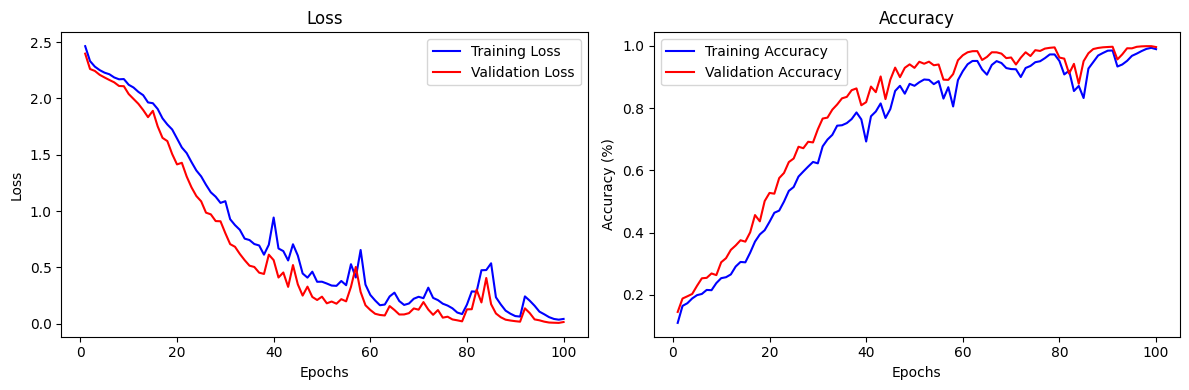

In [ ]:
# Plotting training and validation loss/accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs[:len(history.history['loss'])], history.history['loss'], 'b', label='Training Loss')
plt.plot(epochs[:len(history.history['val_loss'])], history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs[:len(history.history['accuracy'])], history.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(epochs[:len(history.history['val_accuracy'])], history.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Model size: {os.path.getsize('audio_classification_lstm.keras') / 1e6} MB")

Model size: 1.008876 MB


In [ ]:
batch_size=1

# Convert Keras model to a ConcreteFunction
full_model = tf.function(lambda x: model(x))

# Explicitly define the batch size for the input tensor
concrete_function = full_model.get_concrete_function(
    tf.TensorSpec([1, max_pad_len, n_mfcc], model.inputs[0].dtype)  # Batch size of 1, fixed sequence length
)
# Get the frozen ConcreteFunction graph
frozen_func = convert_variables_to_constants_v2(concrete_function)
frozen_graph = frozen_func.graph

# Set up profiler options for calculating FLOPs
opts = ProfileOptionBuilder.float_operation()

# Create profiling context and calculate FLOPs
flops_profile = profile(frozen_graph, options=opts)

# Extract total floating point operations (FLOPs)
flops = flops_profile.total_float_ops

for op in frozen_func.graph.get_operations():
    if op.outputs:
        for output in op.outputs:
            if not output.shape.is_fully_defined():
                print(f"Incomplete shape in operation: {op.name}, shape: {output.shape}")

print(f"FLOPs: {flops}")
print(f"M-FLOPs: {flops / 1e6}")

FLOPs: 14610056
M-FLOPs: 14.610056


# LSTM model - improved model

In [29]:
# Define the LSTM model
def create_lstm_model(input_shape, num_classes):
    model = models.Sequential()

    # LSTM layer
    model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=False, unroll=True))  # Use unroll=True

    # Add dense layers
    # model.add(layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [30]:
# Parameters
n_mfcc = 13
max_pad_len = 100
num_channels = 1
input_shape = (max_pad_len, n_mfcc)  # Input shape is now (time_steps, features)
num_classes = 12  # 10 words + "is_unknown" + "_silence_"
num_epochs = 180

# Create the LSTM model
model = create_lstm_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert list of MFCC arrays into a single NumPy array
train_audio = np.array(mfccs_dic['train']['audio'])
train_labels = np.array(mfccs_dic['train']['labels'])
test_audio = np.array(mfccs_dic['test']['audio'])
test_labels = np.array(mfccs_dic['test']['labels'])
validation_audio = np.array(mfccs_dic['validation']['audio'])
validation_labels = np.array(mfccs_dic['validation']['labels'])

# Reshape the data to match LSTM expected input shape (batch_size, time_steps, features)
train_audio = train_audio.reshape(train_audio.shape[0], max_pad_len, n_mfcc)
test_audio = test_audio.reshape(test_audio.shape[0], max_pad_len, n_mfcc)
validation_audio = validation_audio.reshape(validation_audio.shape[0], max_pad_len, n_mfcc)

# One-hot encode the labels
train_labels = to_categorical(train_labels, num_classes=12)
test_labels = to_categorical(test_labels, num_classes=12)
validation_labels = to_categorical(validation_labels, num_classes=12)

# Add early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM model
history = model.fit(train_audio, train_labels, epochs=num_epochs, batch_size=96, validation_data=(validation_audio, validation_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_audio, test_labels)
print("########## TEST THE MODEL ##########")
print(f'test accuracy: {test_acc}\n test loss: {test_loss}')

# Save the model
model.save('audio_classification_lstm.keras')

Epoch 1/180
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 215ms/step - accuracy: 0.0965 - loss: 2.4779 - val_accuracy: 0.1397 - val_loss: 2.4399
Epoch 2/180
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.1352 - loss: 2.4367 - val_accuracy: 0.1759 - val_loss: 2.3528
Epoch 3/180
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.1640 - loss: 2.3201 - val_accuracy: 0.1955 - val_loss: 2.2469
Epoch 4/180
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.1736 - loss: 2.2695 - val_accuracy: 0.2053 - val_loss: 2.2286
Epoch 5/180
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.1909 - loss: 2.2426 - val_accuracy: 0.2186 - val_loss: 2.2129
Epoch 6/180
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.2110 - loss: 2.2103 - val_accuracy: 0.2202 - val_loss: 2.1860
Epoch 7/180
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.1989 - loss: 2.2012 - val_accuracy: 0.2323 - val_loss: 2.1863
Epoch 8/180
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.2138 - loss: 2.1919 - val_

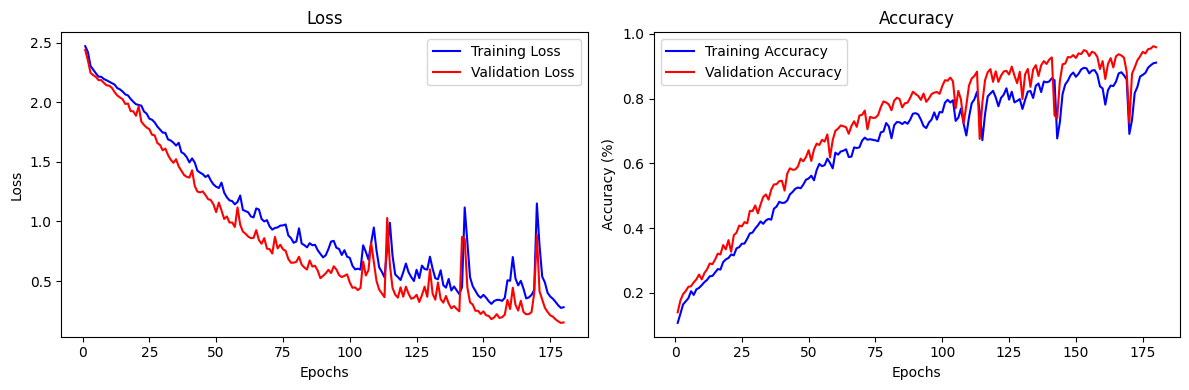

In [31]:
# Plotting training and validation loss/accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs[:len(history.history['loss'])], history.history['loss'], 'b', label='Training Loss')
plt.plot(epochs[:len(history.history['val_loss'])], history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs[:len(history.history['accuracy'])], history.history['accuracy'], 'b', label='Training Accuracy')
plt.plot(epochs[:len(history.history['val_accuracy'])], history.history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
print(f"Model size: {os.path.getsize('audio_classification_lstm.keras') / 1e6} MB")

Model size: 0.325864 MB


In [33]:
batch_size=1

# Convert Keras model to a ConcreteFunction
full_model = tf.function(lambda x: model(x))

# Explicitly define the batch size for the input tensor
concrete_function = full_model.get_concrete_function(
    tf.TensorSpec([1, max_pad_len, n_mfcc], model.inputs[0].dtype)  # Batch size of 1, fixed sequence length
)
# Get the frozen ConcreteFunction graph
frozen_func = convert_variables_to_constants_v2(concrete_function)
frozen_graph = frozen_func.graph

# Set up profiler options for calculating FLOPs
opts = ProfileOptionBuilder.float_operation()

# Create profiling context and calculate FLOPs
flops_profile = profile(frozen_graph, options=opts)

# Extract total floating point operations (FLOPs)
flops = flops_profile.total_float_ops

for op in frozen_func.graph.get_operations():
    if op.outputs:
        for output in op.outputs:
            if not output.shape.is_fully_defined():
                print(f"Incomplete shape in operation: {op.name}, shape: {output.shape}")

print(f"FLOPs: {flops}")
print(f"M-FLOPs: {flops / 1e6}")

FLOPs: 4029064
M-FLOPs: 4.029064
